# Notebook 9 - GANs for MNIST digit generation

CSI4106 Artificial Intelligence   
Fall 2021  
Version 1 (2020) prepared by Julian Templeton and Caroline Barrière.  Version 2 (2021) modified by Caroline Barrière.

***INTRODUCTION (Please read this carefully!)***:  

With the ressurgence of Deep Learning and Deep Learning Architectures (DLAs) due to the increased power of modern computing, there are a multitude of ways in which DLAs can be used to tackle essentially every type of tasks (from face recognition, to stock market prediction, to image generation, ...).    

Generative AI, with its generation of fake images, videos, music, and text (ex: poems) is a topic of interest in society. Generative AI can have practical applications, if we think for example to automatically generating text illustrations to help language learners, but generative AI can have major ethical implications as well. 

From a techonological point of view, generative AI, largely made possible with the help of DLAs, can be implemented easily through the use of prominent Python Deep Learning libraries such as [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/), and [Keras](https://keras.io/). Still, although it is possible to find many examples of how these DLAs can be used, they do require immense computational power to provide effective results. Futhermore, as you will notice in this Notebook, the quality of results can vary widely if there is no notable effort into fine-tuning hyperparameters (which can take a long time!).

In this notebook we will be exploring a common image generation task through the use of a Generative Adversarial Network (GAN). Starting with randomly generated images like this    

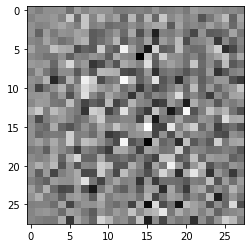     

the GAN will learn to generate images of digits like this (in this image, this digit is '1')  

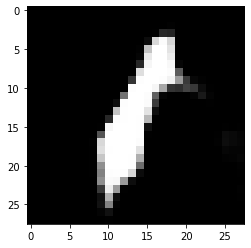

There are many types of GANs, each with different pros and cons. In this notebook we will be working with a DCGAN (Deep Convolutional GAN). A DCGAN is similar to a GAN, but introduces convolutional layers into its network to increase performance over the GAN's simple, fully connected network. Convolutional layers are commonly used in Convolutional Neural Networks, thus the DCGAN will showcase how these can be translated into the design of a GAN's Generator and Discriminator. To review these concepts you can look at the optional video in Module 6 on Brightspace to learn about convolutional layers in Convolutional Neural Networks (CNNs).        

As alluded to above, DLAs such as GANs require immense computational processing. This typically requires a high- to top-end graphics card such as the latest cards from NVIDIA (which provide tools, such as [CUDA](https://developer.nvidia.com/cuda-zone) to allow code to be executed on the GPU for fast processing). Since we cannot expect you to have a graphics card or to spend the time waiting for a CPU  to perform the computations, we will be using [Google Colab](https://colab.research.google.com/) which is a free, cloud-based jupyter environment that is great to perform basic Deep Learning experiments on since it provides access to some very powerful graphics cards (that have limits, but these should not occur for the duration of this notebook). These limits include time constraints and memory limitations that may occur if we run a training algorithm for too many epochs or if we design a model that has too many hidden nodes. 

Many of you have already switched to Colab for previous notebooks, perhaps because of installation issues on your home computer.  If you have already switched, then, you know how to use Colab already.  If you haven't switched yet, you should definitely use Colab for this Notebook unless you have your own GPUs at home.

Unlike previous notebooks, this notebook will focus on the exploration of ideas and the analysis of results since it would be beyond the scope of the course to learn a complex new library and program a complex Deep Learning model with it. Therefore, although this notebook contains a lot of code, most of the code was written last year by Julian Templeton, and you do not have to modify it.  

This notebook is based on the [official TensorFlow example of creating a DCGAN](https://www.tensorflow.org/tutorials/generative/dcgan). The code used here is inspired by the example and adapted to tune performance and work in Google Colab. Thus, note that the code used here originates from this example with modifications when needed.    

**IMPORTANT:  When submitting this notebook, ensure that you do NOT reset the outputs from running the code so that the correctors can directly have access to your GAN's results (plus remember to save the notebook with ctrl+s).**

***HOMEWORK***:  
Go through the notebook by running each cell, one at a time.  
Look for **(TO DO)** for the tasks that you need to perform. Do not edit the code outside of the questions which you are asked to answer unless specifically asked. Once you're done, sign the notebook (at the end of the notebook), rename it to *StudentNumber-LastName-Notebook9.ipynb* and submit it.  

*The notebook will be marked on 23.  
Each **(TO DO)** has a number of points associated with it.*
***

**1.0 - Setting up the Google Colab Environment**   

Before going straight into the code, we need to first set up our Google Colab environment. To do so we will need to install some libraries with pip (will need to do this each time we run through the notebook), and we will need to enable GPU access for this notebook within Google Colab.   

We will first initialize GPU access for the notebook. Google will ask that you turn it off when not in use, but you will be able to easily complete the notebook without issue. There are some limitations on how long it can be run for consecutively (many hours) and the total memory that can be used (around 12 GB depending on the allocated card), but these will not be issues for this notebook. Furthermore, Google may allocate different GPUs for each user. This may mean that you get allocated a slightly slower or faster card, but all GPUs will be more than sufficient to run these advanced models with ease. If a GPU-related issue occurs you will need to restart the notebook or disconnect/reconnect to a new GPU after a few minutes. However, this will be unlikely to occur during the notebook.  Make sure that when you are done with your colab session, you manually end it (go in *runtime*, *manage sessions*).

**To connect to a GPU, go to *Edit* in the toolbar, select *Notebook settings*,  select *GPU* as the hardware accelerator, and click *Save*.**

Next, run the following pip installs and import functions to set up TensorFlow and all other llibraries that we will use. Note that several libraries that we have used in previous notebooks return for solving this problem.

In [15]:
# Install the specified libraries
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [1]:
# Import TensorFlow (note that this also will provide us with the MNIST dataset thanks to Keras)
import tensorflow as tf
import tensorflow_docs.vis.embed as embed
from tensorflow.keras import layers

# Install additional libraries to help define our arrays, images, and more
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display

**2.0 - Importing the Dataset**   

Now that the environment is ready, we will load the MNIST dataset that is provided to us by the standard datasets within TensorFlow. The MNIST dataset is a dataset that consists of images of handwritten digits (0, 1, 2, ..., 9). Below we load the data into our training sets (recall that we have no testing set since the GAN will be continuously training to improve itself, unlike the classification of the digits which would require a testing set). Then we look at the number of images that we will be using for training in the dataset and display and example image along with the digit that it represents.

In [2]:
# Load the handwritten digit images and their labels from the dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# Show how many images are in the dataset
print("There are", len(train_images), "many handwritten digits that can be used for training the DCGAN.")

There are 60000 many handwritten digits that can be used for training the DCGAN.


The following image represents the handwritten digit 5
The image has the dimensions: (28, 28) and is grayscale.


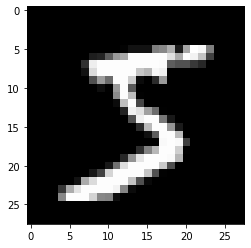

In [4]:
# Which digit is being shown
print("The following image represents the handwritten digit", train_labels[0])
# What are its dimensions
print("The image has the dimensions:", train_images[0].shape, "and is grayscale.")
# Display the digit
plt.imshow(train_images[0], cmap='gray')

Below we can see the actual values for the grayscale image. As you can see, each pixel receives a single value between 0 and 255 to represent the grayscale to display for that pixel. We look at this since we will be normalizing these pixel values and modifying the structure of the image to be ready for use when training in batches.

In [5]:
# Understand the structure of the image and the pixel values used.
train_images[1]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

Next, we will alter the received data to be ready to be used by the learning algorithms. We change the structure to add an additional dimension that simply states that the set of pixels represents a single digit. This helps since our models will need to work with batches of images and clearly know which pixels belong to which image.    

The smaller an image's dimensions and the less values per pixel (i.e. 1 for grayscale and 3 for RGB) results in faster training (but a loss in data if the size is reduced). This image's size is fine (28 by 28), but we will normalize the pixel values from 0 to 255 to be within -1 and 1. Since Machine Learning algorithms learn from data, we typically want to normalize larger values from smaller values to ensure that the model learns the correct patterns and to minimize the cost of performing calculations with large numbers.

In [6]:
# Restructure the numpy array to display the pixel values as 28 (width) by 28 (height) by 1 (one image)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

Below we take a quick look at the pixel values for the first image of our modified training set (to view the normalization and new structure) along with a quick view of the image itself (which will look the exact same, but be plotted differently to match its new structure.

In [7]:
# Look at the normalized pixel values
print(train_images[0])

[[[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]]

 [[-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-1.        ]
  [-

The following image represents the handwritten digit 5


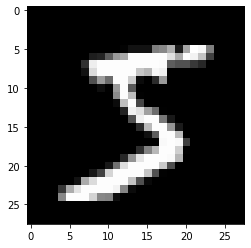

In [8]:
# Which digit is being shown
print("The following image represents the handwritten digit", train_labels[0])
# Look at the updated image (will look the same)
plt.imshow(train_images[0][:, :, 0], cmap='gray')

Now, we reduce to a subset of digits, so that the training time is reduced.  So our DCGAN will learn to generate digits 1, 5 and 8 only.  *You can certainly try with a larger (but not smaller) subset if you want. Make sure you specify which subset you used in your answers.*

In [9]:
# Subset of 3 digits (just to reduce runtime - feel free to test with a larger subset)
reduced_train_images = []
# Populate with only 1, 5, 8  
for x in range(len(train_images)):
  if train_labels[x] in [1, 5, 8]: 
    reduced_train_images.append(train_images[x])

In [10]:
# Instead of 60K images, we now have:
print(len(reduced_train_images))

18014


**3.0 - Defining and training the DCGAN**   

To design the DCGAN, we need to define the various layers within the Neural Networks that are used by the Generator and Discriminator. Each of these models will require its own Neural Network since the two are competing with each other.      



***3.1 Defining the Generator***

Below we define the Generator to be a Sequential set of Convolutional Layers and activation functions (*Leaky ReLU is used here*) that take an input and outputs a 28 by 28 by 1 image. The values that are passed to the model are random values (referred to as *noise*) based on some probability distribution. The total number of values used as input is referred to as the *latent dimension* (in this example, it is 40). The goal of the Generator is to run the noise through its Neural Network to end up with an handwritten digit as an output.    

The Generator has one parameter, a *batch_size*.  This is used to determine how many input images are looked at at once before readjusting weights (performing *Batch Normalization*).  The exact behavior of this normalization is beyond the scope of this class, but we can remember that it is a hyperparameter to be set that will influence the results.  In general, a larger batch size makes the learning faster and more stable as the network is not constantly changing the weights based on just a few examples.

The Generator defined below has four total layers. The input layer accepts the random noise as input (ouputting a larger number of outputs), performs *Batch Normalization* to help improve results, and runs the output through the *Leaky ReLU* activation function. This then goes into the first of three convolutional layers which each feed into each other after performing *Batch Normalization* and using the *Leaky ReLU* activation function. These each reduce the number of outputs to the final size of the image that we desire (28 by 28 bu 1).

In [20]:
# Defining the Generator
def make_generator_model(batch_size):
    '''
    Defines a Generator to accept rnadom noise based on a probability distribution
    and run it through a Neural Network of three convolutional layers with the Leaky ReLU
    activiation function and Batch Normalization (which makes the learning process faster and more stable)
    '''
    model = tf.keras.Sequential()
    # Layer 1
    model.add(layers.Dense(7*7*batch_size, use_bias=False, input_shape=(40,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, batch_size)))
    assert model.output_shape == (None, 7, 7, batch_size) # Note: None is the batch size

    # Layer 2
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 3
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 4
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    # Return the Generator
    return model

Below we create the generator that we will be using and look at an example output when passing random noise into the untrained model. As you can see, it currently has no representation of a handwritten digit as it has not learned the patterns from the digit images.

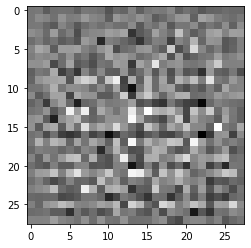

In [21]:
# Setting the batch size 
BATCH_SIZE = 256
# Define the Generator
generator = make_generator_model(BATCH_SIZE)
# Generate a random noise input
noise = tf.random.normal([1, 40])
# Retrieve the outputted image from the Generator for the input
generated_image = generator(noise, training=False)
# Display the image generated by the Generator
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

***3.2 Defining the Discriminator***

Next we define the Discriminator. The Discriminator accepts an image as input (with the expected dimensions) and runs it through a simple set of convolutional layers to output whether the image is real or fake. This model will be training against the Generator in an attempt to learn the attributes of fake and real handwritten digits. The Discriminator is defined to have two convolutional layers that are mostly the same as what we have used in the Generator. Notice that the convolutional layers increase in size, rather than decrease in size.

In [24]:
# Defining the discriminator
def make_discriminator_model():
    '''
    Create a Discriminator with two convolutional layers that accept a
    handwritten digit image as input and outputs whether it is true or false.
    Note that the Dropout code refers to the Dropout regularization technique that 
    can be used to enhance the performance of a Neural Network and achieve strong
    results quicker than normal.
    '''
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Below exhibits what the untrained Discriminator outputs when we provide the image created by the Generator in the example above as input. Note that negative numbers mean that the image is predicted to be fake while positive numbers mean that the image is predicted to be real.

In [25]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00148912]], shape=(1, 1), dtype=float32)


***3.3 Defining the loss functions and optimizers***

With the models defined, we will now define the loss functions to be used when training and the optimizers to use. We will not go into detail regarding the code here, except for the parameter used for the Adam optimizer. However, comments have been added to explain the code at a high-level.

And you probably remember the cross-entropy as the loss function being used for binary classification.  We use it again here.

In [26]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [27]:
def discriminator_loss(real_output, fake_output):
    '''
    The loss function for the discriminator.
    This must consider the combined loss from how well it performs at detecting fake and
    real images.
    '''
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [28]:
def generator_loss(fake_output):
    '''
    The Generator loss is simply based on whether the generated image was able to 
    trick the discriminator in believing that the fake image is real.
    '''
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Below, the optimizers used to train the models are selected. We also used optimizers when working in the MLP notebook with scikit-learn. The main thing to note here is that the number being passed as input is the learning rate to be used by the models, which we need to define first. 

In [29]:
# Define the learning rate to be used by the optimizers
lr = 1e-4
# Set the optimizers that will be used by both models and set the learning rate.
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

***3.4 Defining the training approach***

Now we will define the training functions. The *train_step* function below accepts a batch of images from the training set as input and first collected a batch of fake images from the Generator. The Discriminator then attempts to determine, from the set of real images and the set of fake images, which images are real and which are fake. The loss from both models are then computed to find the gradients and backpropagate through the models to update the Generator and the Discriminator.

In [30]:
noise_dim = 40
num_examples_to_generate = 16
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim], seed=0)

In [31]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, batch_size):
    '''
    For a single batch of images from the training set, train the Discriminator
    and Generator.
    This function will automatically run on the default GPU of the system if it
    can be detected by the environment.
    '''
    # Generate the batch of random noise inputs to be used to create the fake images
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generate the fake images
      generated_images = generator(noise, training=True)
      # Have the Discriminator determine which images are real or fake from both sets of images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      # Calculate the loss for both the generator and the discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for both the Generator and the Dsicriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Update the models by applying the gradients to the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [32]:
def train(dataset, epochs):
    '''
    Trains a Generator and Discriminator with a specified dataset for a specified
    number of Epochs. Example outputs are saved to be visualized later.
    '''
    for epoch in range(epochs):
      start = time.time()
      # Loop through each batch in the training set
      for image_batch in dataset:
        # Train the models with the specified batch
        train_step(image_batch, BATCH_SIZE)

      # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)

Similarly to what we used in the MLP notebook, we create a training function that trains each model with the entirety of the training set (in batches) for a certain number of epochs. After each epoch, a set of 16 example fake images are output to visualize the process. 

In [33]:
def generate_and_save_images(model, epoch, test_input):
  '''
  Generates fake images based on the Generator after being trained for a 
  specified number of epochs. We set the model to not train while generating the
  images to ensure that only the training function will train the model.
  '''
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

***3.5 - Training the DCGAN***   

Now that the DCGAN is defined, we need to set a few parameters for training.

Similarly to the MLP notebook, we now determine how many epochs the model should be trained for. Although this will take minutes to complete, 50 will be enough to see how the model's fake images evolve. 

Then we have the *batch_size* (as we discussed earlier that is used by the Generator for batch normalization). 

And the *buffer_size* is a parameter used for a shuffle of the order of the examples. We let this shuffle take place among the whole set by setting it to the size of the training set.


In [34]:
EPOCHS = 50
BATCH_SIZE = 256 # Define the batch size
BUFFER_SIZE = len(reduced_train_images) # or 60000 if we use the full dataset

Now we will train the DCGAN! Each epoch will take around 10-12 seconds, so you will see how it updates over the 50 epochs that we will run it for. In reality we may optimize the model more or run for more epochs, but this is enough to visualize the progress within the notebook.

In [35]:
# build dataset
train_dataset = tf.data.Dataset.from_tensor_slices(reduced_train_images).shuffle(BUFFER_SIZE, seed=0).batch(BATCH_SIZE)

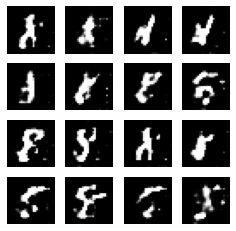

In [36]:
# Remember to turn ON the GPU in Google Colab (the speed that it runs at will depend on the GPU that you are assigned;
#                                              between 10 and 30 seconds on average on the full MNIST dataset)!!!
# You are expected to run this through all of the epochs, not just a subset of them since everyone has the computation power for it.
train(train_dataset, EPOCHS)

With the training completed, we will display some the collection of fake images that we displayed for epoch 50.

In [37]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

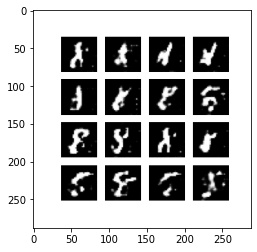

In [38]:
# Display the output from the last epoch (epoch 50)
plt.imshow(display_image(EPOCHS))

**(TO DO) Q1 - 7 marks**    

Now that you've trained the DCGAN to generate digits, you will analyze the results obtained.

**(TO DO) Q1 (a) - 2 marks**    
a) To help you analyze the the evolution of the generated images while the Generator is learning, define the function *display_key_epochs* below. This function must display each collection of fake images that have been outputed for epochs *\[10, 20, 30, 40, 50\]*. After the function is defined, call it to display each collection of fake images from the specified epochs. The code above this question shows how you can retrieve the fake outputs for a specific epoch.  

The image of 10 EPOCHS is: 


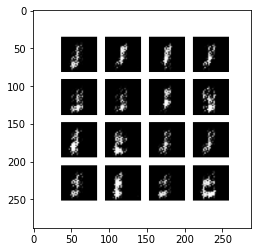

The image of 20 EPOCHS is: 


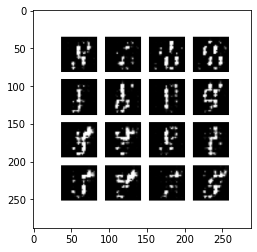

The image of 30 EPOCHS is: 


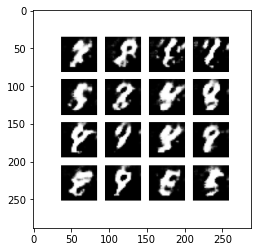

The image of 40 EPOCHS is: 


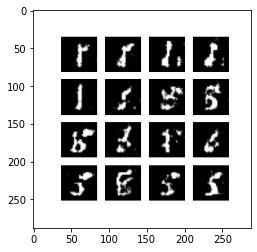

The image of 50 EPOCHS is: 


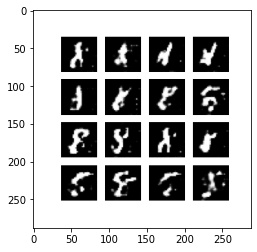

In [39]:
# ANSWER Q1(a)
# Define the function for the target epochs and use it to display the images.
# Note: This function is used later in the notebook and assumes that no input parameters will be added.
def display_key_epochs():
    epochs_list = [10,20,30,40,50]
    for num in epochs_list:
        print('The image of ' + str(num) +' EPOCHS is: ')
        plt.imshow(display_image(num))
        plt.show()
display_key_epochs()

**(TO DO) Q1 (b) - 2 marks**   
b) Based on the observed results from (a), did the model seem to perform well (i.e. do the generated digits look like handwritten digits)?  Explain your answer by referring to specific examples in the results.

**ANSWER Q1(b)**


The model did not perform well, some digits look like handwritten but most of the digits are not. For example, the digit(4,0) in 50 EPOCHS are like number EIGHT in handwritten digits, and some digits are look likes ONE in hand written digits. But most of the digits are unable to read as handwritten digits. Specially for EPOCHS 20,30 and 40.

**(TO DO) Q1 (c) - 1.5 marks**   
c) After visualizing the fake images through the epochs, what is happening to the generated outputs as it continues to be trained in each epoch? Explain why this process is happening.

**ANSWER Q1 (c)**

The generated output are better from EPOCHS 10 to EPOCHS 50. Because the generator are changing its weight because of the back-propagation method.

**(TO DO) Q1 (d) - 1.5 marks**   
d) During the last few epochs, how drastic are the changes being made to the fake images? Do they seem to be improving consistently at the same rate near the end of the training? Why or why not?


**ANSWER Q1 (d)**

According to the images of EPOCHS 47,48,49,50. Each fake image have huge change compare with the previous one. And I don't think the rate are always the same because 50 Epochs are seems not enough for the training.For every epochs, it would have different rate.

**4.0 - Testing Different Hyperparameters**   

After seeing how the entire process is performed, you will be trying the same process out for yourself, but using different hyperparameters. By making minor changes to a small number of parameters, it is possible to obtain very different results. After you complete this process, you will discuss how the results compare with the test that is provided to you in the example above.

**(TO DO) Q2 - 6 marks**    
You will now create a new Generator and Discriminator such that they will work with a *batch size* of 64 images per batch and will set the optimizer to use a larger *learning rate* of 1e-3. This will not require any updates to the defined structures of the Generator and Discriminator and will simply involve copying some code over and making minor modifications. Below is a list of each task that you will need to perform. Each of these should be done in the corresponding code cell below. The structure is provided for you, so you simply must fill in the blanks.    

1) Update the batch size variable to specify that the batches should consist of 64 images and redefine *train_dataset* to use the new batch size.    
2) Redefine the Generator object with the new batch size as input to the function.    
3) Redefine the Discriminator object.     
4) Redefine the *cross_entropy* variable the same way it was previously.    
5) Set the learning rate to 1e-3 and re-define the optimizer variables.     
6) Run the provided *train_step* function to recompile the code after making the above changes.    
7) Train the new models for 50 epochs with the dataset defined in 1)     

In [40]:
# TODO: 1) Update the batch size variable to specify that the batches should consist of 64 images and redefine train_dataset to use the new batch size. 
# Update the batch size
BATCH_SIZE = 64
# Redefine train_dataset
train_dataset1 = tf.data.Dataset.from_tensor_slices(reduced_train_images).shuffle(BUFFER_SIZE, seed=0).batch(BATCH_SIZE)

In [41]:
# TODO: 2) Redefine the Generator object with the new batch size as input to the function. 
generator = make_generator_model(BATCH_SIZE)
noise = tf.random.normal([1, 40])
generated_image = generator(noise, training=False)

In [42]:
# TODO: 3) Redefine the Discriminator object.
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

In [43]:
# TODO: 4) Redefine the cross_entropy variable the same way it was previously
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
# TODO: 5) Set the learning rate to 1e-3 and re-define the optimizer variables
lr = 1e-3
# Set the optimizers that will be used by both models and set the learning rate.
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [45]:
# (6) Re-compile this function to work with the updates (just run this code cell)
@tf.function
def train_step(images, batch_size):
    '''
    For a single batch of images from the training set, train the Discriminator
    and Generator.
    This function will automatically run on the default GPU of the system if it
    can be detected by the environment.
    '''
    # Generate the batch of random noise inputs to be used to create the fake images
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generate the fake images
      generated_images = generator(noise, training=True)
      # Have the Discriminator determine which images are real or fake from both sets of images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      # Calculate the loss for both the generator and the discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for both the Generator and the Dsicriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Update the models by applying the gradients to the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

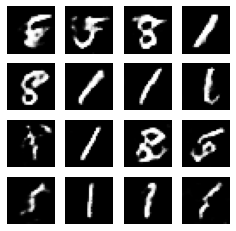

In [46]:
# TODO: 7) Train the new models for 50 epochs with the dataset defined in 1)
EPOCHS = 50
train(train_dataset1, EPOCHS)

**(TO DO) Q3 - 6 marks**   
Now that you have modified the hyperparameters and trained the new DCGAN, you will discuss how this model compares to the model from part 3.0 of this notebook and some observations based on the results.    


**(TO DO) Q3 (a) - 0.5 mark**   
a) Use your *display_key_epochs* function to display the results from the key epochs to use for the rest of the question.

The image of 10 EPOCHS is: 


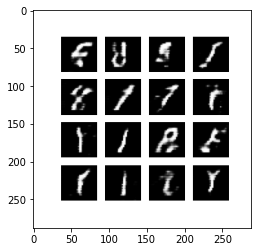

The image of 20 EPOCHS is: 


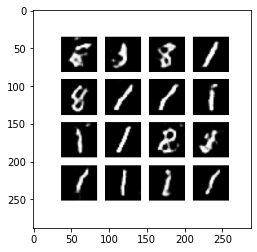

The image of 30 EPOCHS is: 


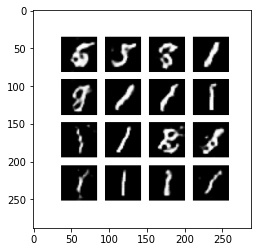

The image of 40 EPOCHS is: 


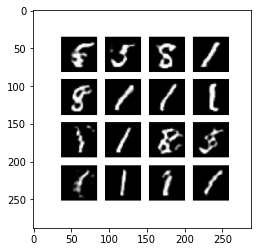

The image of 50 EPOCHS is: 


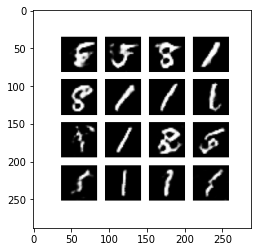

In [47]:
# ANSWER Q3(a) 

# Display the outputs for the key epochs
display_key_epochs()

**(TO DO) Q3 (b) - 2 mark**   
b) Between the model that you defined and trained and the example model from part 3.0, which performed better and why do you think it performed better? 

**ANSWER Q3(b)**

The model I define is better than the medel from part 3.0 . Because most of the digit image can be distinguish as handwritting number of 1,5 or 8.

**(TO DO) Q3 (c) - 2 marks**   
c) Name one pro and one con from increasing the learning rate (based on your observations and/or based on what you know the learning rate does).      

**ANSWER Q3(c)**

With the increase of the learning rate, it may cause the overfitting. But it also reduce the loss

**(TO DO) Q3 (d) - 1.5 marks**   
d) Name one pro and one con from decreasing the batch size (based on your observations and/or based on what you know happens when the batch size is decreased).

**ANSWER Q3(d)**

With the decrease of the batch size, the time cost for training will be large, but it will need fewer epochs to reach the best performances.

**5.0 - Testing a Simpler DCGAN**   
Now that you have explored a basic DCGAN and have played around with the learning rate and batch size hyperparameters, we will go through one final test of an even simpler DCGAN.    

In this scenario, everything will be the same as your setup in section 4.0 of this notebook, except that we will redefine the DCGAN to remove one of the convolutional layers from the Generator and the Discriminator. This will result in a more simplistic model. By comparing the results obtained here to the results obtained in the previous section, you will discuss whether an increased complexity or decreased complexity helps the model generate better fake handwritten digits.

The Generator below now is setup to be the same as before, but now contains only three layers, with two convolutional layers. Specifically, the largest convolutional layer has been removed which results in the input layer's output leading to a smaller convolutional layer.

In [48]:
def make_generator_model(batch_size):
    '''
    Defines a Generator to accept rnadom noise based on a probability distribution
    and run it through a Neural Network of two convolutional layers with the Leaky ReLU
    activiation function and Batch Normalization (which makes the learning process faster and more stable)
    '''
    model = tf.keras.Sequential()
    # Layer 1
    model.add(layers.Dense(7*7*batch_size, use_bias=False, input_shape=(40,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, batch_size)))
    assert model.output_shape == (None, 7, 7, batch_size) # Note: None is the batch size

    # Layer 2
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Layer 3
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    # Return the Generator
    return model

In [49]:
# Define the Generator
generator = make_generator_model(BATCH_SIZE)

Similarly, the Discriminator removed one of its two convolutional layers. This results in only a single convolutional layer to learn how to distinguish which images are real and which are fake.

In [50]:
def make_discriminator_model():
    '''
    Create a Discriminator with one convolutional layer that accept a
    handwritten digit image as input and outputs whether it is true or false.
    Note that the Dropout code refers to the Dropout regularization technique that 
    can be used to enhance the performance of a Neural Network and achieve strong
    results quicker than normal.
    '''
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [51]:
# Define the Discriminator
discriminator = make_discriminator_model()

In [52]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Set the optimizers that will be used by both models and set the learning rate.
generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)

In [53]:
# Re-compile this function to work with the updates
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, batch_size):
    '''
    For a single batch of images from the training set, train the Discriminator
    and Generator.
    This function will automatically run on the default GPU of the system if it
    can be detected by the environment.
    '''
    # Generate the batch of random noise inputs to be used to create the fake images
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generate the fake images
      generated_images = generator(noise, training=True)
      # Have the Discriminator determine which images are real or fake from both sets of images
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      # Calculate the loss for both the generator and the discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for both the Generator and the Dsicriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Update the models by applying the gradients to the models
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

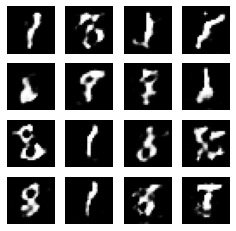

In [54]:
# Remember to turn ON the GPU in Google Colab.
# You are expected to run this through all of the epochs, not just a subset of them since everyone has the computation power for it.
train(train_dataset, EPOCHS)

**(TO DO) Q4 - 6 marks**          
Now that you have changed the network and trained the new DCGAN, you will explain how this model compares to the model in Part 4.0 of this notebook and make some observations based on the results.

**(TO DO) Q4 (a) - 0.5 marks**     
a) Use your *display_key_epochs* function to display the results from the key epochs to use for the rest of the question.

The image of 10 EPOCHS is: 


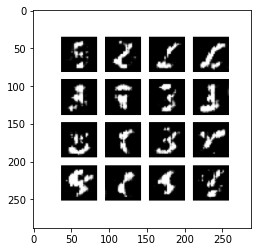

The image of 20 EPOCHS is: 


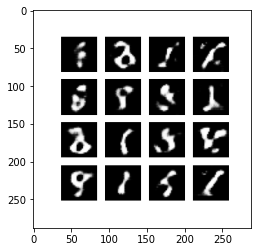

The image of 30 EPOCHS is: 


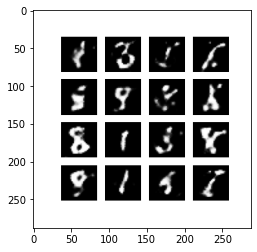

The image of 40 EPOCHS is: 


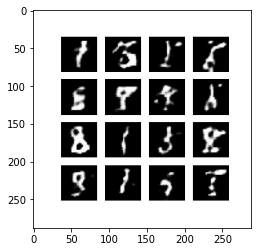

The image of 50 EPOCHS is: 


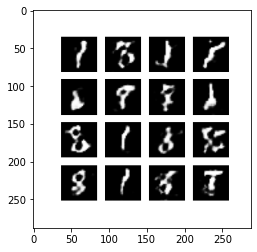

In [55]:
# ANSWER Q4(a) 
display_key_epochs()

**(TO DO) Q4 (b) - 1.5 mark**    
b) How did removing one of the convolutional layers from the Generator and the Discriminator affect the training?

**ANSWER Q4(b)**

It reduce the time needed for each EPOCHS. 

**(TO DO) Q4 (c) - 2 mark**    
(c) How did removing one of the convolutional layers from the Generator and the Discriminator affect the performance of the model when compared to the model from part 4.0? Also, how did removing this affect the results seen from the outputs?

**ANSWER Q4(c)**

The performance is worse, about half of the digit image can be distinguish as the hand written number.

**(TO DO) Q4 (d) - 2 marks**    
d) If the images that we use were larger in size, would a complex model or a simple model be better to use in this scenario? Why or why not?

**ANSWER Q4(d)**`

I prefer the simple model. Because with the image that is larger in size, complex model will have much more time cost than simple model. But the performance of complex model is not much better than simple model. Simple model will have better performance with more Epoch.

***SIGNATURE:***
My name is Tan Chen.
My student number is 300072995.
I certify being the author of this assignment.